# Lecture 2: Words and Word Representations
## Demo Notebook

This notebook accompanies Lecture 2 and demonstrates:
1. Co-occurrence counts and word-context matrices
2. Similarity measures (dot product, cosine similarity)
3. Nearest neighbors (count-based, SVD-based, LSA-based)
4. Word2Vec embeddings
5. Analogy evaluation across all methods

In [1]:
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import load_dataset
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab', quiet=True)

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

np.random.seed(42)

## Loading Simple Wikipedia

We use the [Simple Wikipedia](https://huggingface.co/datasets/rahular/simple-wikipedia) dataset.

In [2]:
# Load Simple Wikipedia dataset (first 100k documents)
print("Loading Simple Wikipedia dataset...")
simplewiki_dataset = load_dataset("rahular/simple-wikipedia", split="train[:100000]")
print(f"Dataset loaded: {len(simplewiki_dataset)} documents")

Loading Simple Wikipedia dataset...
Dataset loaded: 100000 documents


In [3]:
def read_corpus(data, max_docs=None):
    """Loads simple wikipedia and returns tokenized documents."""
    raw_texts = data["text"][:max_docs] if max_docs else data["text"]
    tokenized_docs = [[w.lower() for w in word_tokenize(doc)] for doc in tqdm(raw_texts)]
    return tokenized_docs

print("Tokenizing corpus...")
tokenized = read_corpus(simplewiki_dataset)
print(f"Tokenized {len(tokenized)} documents")
print(f"Sample: {tokenized[1][:15]}...")

Tokenizing corpus...


100%|███████████████| 100000/100000 [00:07<00:00, 14147.01it/s]

Tokenized 100000 documents
Sample: ['april', 'is', 'the', 'fourth', 'month', 'of', 'the', 'year', ',', 'and', 'comes', 'between', 'march', 'and', 'may']...


In [4]:
# Build vocabulary
all_words = [w for doc in tokenized for w in doc]
word_counts = Counter(all_words)

# Filter to words with count >= 5
min_count = 5
vocab = sorted([w for w, c in word_counts.items() if c >= min_count])
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}

print(f"Total tokens: {len(all_words)}")
print(f"Vocabulary size (min_count={min_count}): {len(vocab)}")

Total tokens: 4737939
Vocabulary size (min_count=5): 30354


In [5]:
# Find a example sentence with queen

for doc in tokenized:
    if "queen" in doc:
        pos = doc.index("queen")
        print(" ".join(doc[pos-10:pos+10]))
        break

years later , turing received a posthumous royal pardon from queen elizabeth ii . today , the “ turing law


In [29]:
# most common 50 words
print(word_counts.most_common(500))

[('the', 286229), ('.', 259446), (',', 214881), ('of', 131439), ('and', 109291), ('in', 108036), ('a', 97203), ('to', 81746), ('is', 80107), ('was', 43778), ("''", 43182), ('``', 42333), ('it', 37715), ('are', 37242), (')', 35057), ('(', 35049), ('that', 31463), ('for', 30545), ('as', 28342), ('on', 24687), ('he', 23955), ('by', 23830), ('with', 22203), ('or', 22177), ('they', 22118), ('from', 20954), ('this', 17926), ('be', 17287), ('not', 16825), ('people', 16650), ("'s", 16458), ('an', 15660), ('his', 15538), ('also', 15078), ('have', 14845), ('can', 14308), ('at', 13747), ('were', 13655), ('which', 13633), ('has', 13561), ('many', 12631), ('one', 11749), ('there', 11672), ('called', 11656), ('other', 11619), ('their', 11050), (':', 10891), ('but', 10860), ('some', 10806), ('when', 9862), ('used', 9535), ('most', 9382), ('had', 9344), ('first', 8588), ('about', 8571), ('who', 8445), ('made', 7902), ('more', 7762), ('after', 7696), ('all', 7208), ('its', 7131), ('because', 6958), ('c

---
# Part 1: Co-occurrence Counts

Build a word-context matrix where each cell counts how often words appear together within a window.

In [6]:
def build_cooccurrence_matrix(tokenized_corpus, word2idx, window_size=2):
    """Build a word-context co-occurrence matrix."""
    V = len(word2idx)
    cooccur = np.zeros((V, V), dtype=np.float32)
    
    for doc in tqdm(tokenized_corpus):
        for i, word in enumerate(doc):
            if word not in word2idx:
                continue
            word_idx = word2idx[word]
            start = max(0, i - window_size)
            end = min(len(doc), i + window_size + 1)
            
            for j in range(start, end):
                if i == j:
                    continue
                context_word = doc[j]
                if context_word in word2idx:
                    context_idx = word2idx[context_word]
                    cooccur[word_idx, context_idx] += 1
    
    return cooccur

print("Building co-occurrence matrix...")
cooccur_matrix = build_cooccurrence_matrix(tokenized, word2idx, window_size=2)
print(f"Co-occurrence matrix shape: {cooccur_matrix.shape}")

Building co-occurrence matrix...


100%|███████████████| 100000/100000 [00:04<00:00, 23884.31it/s]

Co-occurrence matrix shape: (30354, 30354)


In [7]:
# Compute pairwise dot products for co-occurrence vectors
print("Computing dot product similarity...")
cooccur_dot_product = linear_kernel(cooccur_matrix)
print(f"Similarity matrix shape: {cooccur_dot_product.shape}")

Computing dot product similarity...
Similarity matrix shape: (30354, 30354)


In [8]:
# Compute pairwise cosine similarity for co-occurrence vectors
print("Computing pairwise cosine similarity...")
cooccur_cosine_sim = cosine_similarity(cooccur_matrix)
print(f"Similarity matrix shape: {cooccur_cosine_sim.shape}")

Computing pairwise cosine similarity...
Similarity matrix shape: (30354, 30354)


---
# Part 2: SVD on Co-occurrence Matrix

Apply Truncated SVD to reduce dimensionality:

$$\mathbf{M} \approx \mathbf{U}_k \mathbf{\Sigma}_k \mathbf{V}_k^\top$$

In [9]:
n_components = 100
print(f"Applying Truncated SVD with {n_components} components...")

svd_cooccur = TruncatedSVD(n_components=n_components, n_iter=10, random_state=42)
svd_cooccur_vectors = svd_cooccur.fit_transform(cooccur_matrix)

print(f"SVD vectors shape: {svd_cooccur_vectors.shape}")
print(f"Explained variance ratio: {svd_cooccur.explained_variance_ratio_.sum():.2%}")

# Compute cosine similarity
svd_cooccur_cosine_sim = cosine_similarity(svd_cooccur_vectors)

Applying Truncated SVD with 100 components...
SVD vectors shape: (30354, 100)
Explained variance ratio: 99.93%


# Part 3: LSA (Latent Semantic Analysis)

Apply SVD to **TF-IDF weighted document-word matrix**:
- Rows: documents
- Columns: words
- Entries: TF-IDF weights (term frequency × inverse document frequency)

TF-IDF downweights common words and emphasizes distinctive terms, giving better semantic representations than raw counts.

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer

# Build document-word matrix with raw counts, then apply TF-IDF
def build_doc_word_matrix(tokenized_corpus, word2idx):
    """Build a document-word count matrix."""
    n_docs = len(tokenized_corpus)
    V = len(word2idx)
    doc_word = np.zeros((n_docs, V), dtype=np.float32)
    
    for doc_idx, doc in enumerate(tqdm(tokenized_corpus)):
        for word in doc:
            if word in word2idx:
                word_idx = word2idx[word]
                doc_word[doc_idx, word_idx] += 1
    
    return doc_word

print("Building document-word matrix...")
doc_word_counts = build_doc_word_matrix(tokenized, word2idx)

# Apply TF-IDF weighting (returns sparse matrix for efficiency)
print("Applying TF-IDF weighting...")
tfidf_transformer = TfidfTransformer()
doc_word_matrix = tfidf_transformer.fit_transform(doc_word_counts)

print(f"Document-word matrix shape: {doc_word_matrix.shape}")
print(f"  (documents x words, TF-IDF weighted, sparse)")

Building document-word matrix...


100%|███████████████| 100000/100000 [00:02<00:00, 35740.72it/s]


Applying TF-IDF weighting...
Document-word matrix shape: (100000, 30354)
  (documents x words, TF-IDF weighted, sparse)


In [11]:
doc_word_matrix.shape

(100000, 30354)

In [12]:
# Apply SVD to TF-IDF matrix to get LSA word vectors
# We need word vectors, so we use V^T from the SVD decomposition
print(f"Applying SVD with {n_components} components for LSA (on TF-IDF matrix)...")

svd_lsa = TruncatedSVD(n_components=n_components, n_iter=10, random_state=42)
doc_vectors = svd_lsa.fit_transform(doc_word_matrix)  # U * Sigma

# Word vectors are the columns of V^T (or rows of V)
# svd.components_ gives V^T (n_components x n_features)
# So we transpose to get word vectors (n_features x n_components)
lsa_word_vectors = svd_lsa.components_.T  # (vocab_size x n_components)

print(f"LSA word vectors shape: {lsa_word_vectors.shape}")
print(f"Explained variance ratio: {svd_lsa.explained_variance_ratio_.sum():.2%}")

# Compute cosine similarity
lsa_cosine_sim = cosine_similarity(lsa_word_vectors)

Applying SVD with 100 components for LSA (on TF-IDF matrix)...
LSA word vectors shape: (30354, 100)
Explained variance ratio: 14.31%


## Compare Nearest Neighbors Across Methods

In [34]:
def find_nearest_neighbors(word, word2idx, idx2word, sim_matrix, k=5):
    """Find k nearest neighbors using precomputed similarity matrix."""
    if word not in word2idx:
        return []
    
    word_idx = word2idx[word]
    similarities = sim_matrix[word_idx]
    top_indices = np.argsort(similarities)[::-1][:k+1]
    
    results = []
    for idx in top_indices:
        if idx != word_idx:
            results.append((idx2word[idx], similarities[idx]))
        if len(results) >= k:
            break
    return results

focus_words = ['king', 'queen', 'man', 'woman', 'university', 'chicago', 'biology', 'guitar', 'company']
focus_words = [w for w in focus_words if w in word2idx]

In [35]:
# Compare all three count-based methods
print("Nearest Neighbors Comparison (top 3)")
print("="*90)

for word in focus_words:
    dot_product_nn = find_nearest_neighbors(word, word2idx, idx2word, cooccur_dot_product, k=3)
    cooccur_nn = find_nearest_neighbors(word, word2idx, idx2word, cooccur_cosine_sim, k=3)
    svd_nn = find_nearest_neighbors(word, word2idx, idx2word, svd_cooccur_cosine_sim, k=3)
    lsa_nn = find_nearest_neighbors(word, word2idx, idx2word, lsa_cosine_sim, k=3)
    
    print(f"\n{word}:")
    print(f"  Co-occurrence dot product: {', '.join([w for w, _ in dot_product_nn])}")
    print(f"  Co-occurrence consine similarity: {', '.join([w for w, _ in cooccur_nn])}")
    print(f"  SVD(cooccur):  {', '.join([w for w, _ in svd_nn])}")
    print(f"  LSA(doc-word): {', '.join([w for w, _ in lsa_nn])}")

Nearest Neighbors Comparison (top 3)

king:
  Co-occurrence dot product: the, of, ,
  Co-occurrence consine similarity: governor, queen, ruler
  SVD(cooccur):  queen, chief, chancellor
  LSA(doc-word): vi, henry, edward

queen:
  Co-occurrence dot product: the, ,, of
  Co-occurrence consine similarity: king, lord, chief
  SVD(cooccur):  king, chief, director
  LSA(doc-word): elizabeth, consort, vi

man:
  Co-occurrence dot product: ,, the, of
  Co-occurrence consine similarity: woman, girl, student
  SVD(cooccur):  woman, girl, student
  LSA(doc-word): servant, woman, haley

woman:
  Co-occurrence dot product: of, ,, .
  Co-occurrence consine similarity: man, person, girl
  SVD(cooccur):  man, worker, girl
  LSA(doc-word): pregnant, girl, nurse

university:
  Co-occurrence dot product: the, of, .
  Co-occurrence consine similarity: height, age, length
  SVD(cooccur):  height, composition, rate
  LSA(doc-word): wesleyan, ateneo, universities

chicago:
  Co-occurrence dot product: the, ,

---
# Part 4: Word2Vec

Prediction-based embeddings: predict context words from center word.

$$P(o|c) = \frac{\exp(u_o^\top v_c)}{\sum_{w \in V} \exp(u_w^\top v_c)}$$

In [15]:
from gensim.models import Word2Vec

print("Training Word2Vec...")
model = Word2Vec(
    sentences=tokenized,
    vector_size=100,
    window=5,
    min_count=5,
    sg=1,  # Skip-gram
    workers=4,
    seed=42
)
word_vectors = model.wv
print(f"Trained word vectors for {len(word_vectors)} words")

Training Word2Vec...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

Trained word vectors for 30354 words


In [18]:
# Word2Vec nearest neighbors
print("Word2Vec Nearest Neighbors (top 5):")
for word in focus_words:
    if word in word_vectors:
        similar = word_vectors.most_similar(word, topn=5)
        print(f"  {word}: {', '.join([w for w, _ in similar])}")

Word2Vec Nearest Neighbors (top 5):
  king: edward, vi, viii, throne, harald
  queen: elizabeth, regnant, empress, consort, margrethe
  man: woman, girl, men, teenager, werther
  woman: man, girl, baby, pregnant, female
  city: town, capital, rotterdam, cities, seaport
  country: nation, mali, lesotho, malawi, azerbaijan
  good: bad, keen, excellent, worthy, happy
  bad: terrible, uncomfortable, harsh, good, trouble


---
# Part 5: Analogy Evaluation

Evaluate all embedding methods on the Google analogy dataset.

For analogy **a : b :: c : ?**, compute $\vec{b} - \vec{a} + \vec{c}$ and find nearest neighbor.

In [19]:
import urllib.request
import os

# Download Google analogy dataset
analogy_url = "https://raw.githubusercontent.com/nicholas-leonard/word2vec/master/questions-words.txt"
analogy_file = "questions-words.txt"

if not os.path.exists(analogy_file):
    print("Downloading Google analogy dataset...")
    urllib.request.urlretrieve(analogy_url, analogy_file)

def load_analogy_dataset(filepath):
    """Load Google analogy dataset."""
    analogies = {}
    current_category = None
    
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip().lower()
            if line.startswith(':'):
                current_category = line[2:]
                analogies[current_category] = []
            elif line and current_category:
                parts = line.split()
                if len(parts) == 4:
                    analogies[current_category].append(parts)
    return analogies

analogy_dataset = load_analogy_dataset(analogy_file)
print(f"Loaded {len(analogy_dataset)} analogy categories")

# Show total questions
total = sum(len(q) for q in analogy_dataset.values())
print(f"Total questions: {total}")

Loaded 14 analogy categories
Total questions: 19544


In [20]:
def evaluate_analogies_matrix(vectors, word2idx, idx2word, analogy_dataset):
    """
    Evaluate analogies using a word vector matrix.
    For a:b::c:d, compute b - a + c and find nearest neighbor.
    """
    # Normalize vectors for cosine similarity
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    norms[norms == 0] = 1
    vectors_norm = vectors / norms
    
    results = {}
    
    for category, questions in analogy_dataset.items():
        correct = 0
        total = 0
        skipped = 0
        
        for a, b, c, expected in questions:
            # Check if all words are in vocabulary
            if not all(w in word2idx for w in [a, b, c, expected]):
                skipped += 1
                continue
            
            total += 1
            
            # Get indices
            a_idx, b_idx, c_idx = word2idx[a], word2idx[b], word2idx[c]
            expected_idx = word2idx[expected]
            
            # Compute b - a + c
            query = vectors_norm[b_idx] - vectors_norm[a_idx] + vectors_norm[c_idx]
            query_norm = query / (np.linalg.norm(query) + 1e-10)
            
            # Find most similar (excluding a, b, c)
            similarities = vectors_norm @ query_norm
            similarities[[a_idx, b_idx, c_idx]] = -np.inf  # exclude input words
            
            predicted_idx = np.argmax(similarities)
            
            if predicted_idx == expected_idx:
                correct += 1
        
        accuracy = correct / total if total > 0 else 0
        results[category] = {
            'correct': correct,
            'total': total,
            'skipped': skipped,
            'accuracy': accuracy
        }
    
    return results

def evaluate_analogies_gensim(wv, analogy_dataset):
    """Evaluate analogies using gensim KeyedVectors."""
    results = {}
    
    for category, questions in analogy_dataset.items():
        correct = 0
        total = 0
        skipped = 0
        
        for a, b, c, expected in questions:
            if not all(w in wv for w in [a, b, c, expected]):
                skipped += 1
                continue
            
            total += 1
            
            try:
                predicted = wv.most_similar(positive=[b, c], negative=[a], topn=1)[0][0]
                if predicted == expected:
                    correct += 1
            except:
                pass
        
        accuracy = correct / total if total > 0 else 0
        results[category] = {
            'correct': correct,
            'total': total,
            'skipped': skipped,
            'accuracy': accuracy
        }
    
    return results

def summarize_results(results, name):
    """Summarize analogy results."""
    total_correct = sum(r['correct'] for r in results.values())
    total_questions = sum(r['total'] for r in results.values())
    overall_acc = total_correct / total_questions if total_questions > 0 else 0
    return {
        'name': name,
        'overall_accuracy': overall_acc,
        'total_correct': total_correct,
        'total_questions': total_questions,
        'by_category': results
    }

In [21]:
# Evaluate all methods
print("Evaluating all embedding methods on analogy task...")
print("(This may take a few minutes)\n")

all_results = {}

# 1. Raw co-occurrence
print("1. Evaluating Co-occurrence vectors...")
cooccur_results = evaluate_analogies_matrix(cooccur_matrix, word2idx, idx2word, analogy_dataset)
all_results['Co-occurrence'] = summarize_results(cooccur_results, 'Co-occurrence')

# 2. SVD on co-occurrence
print("2. Evaluating SVD(co-occurrence) vectors...")
svd_results = evaluate_analogies_matrix(svd_cooccur_vectors, word2idx, idx2word, analogy_dataset)
all_results['SVD(cooccur)'] = summarize_results(svd_results, 'SVD(cooccur)')

# 3. LSA (SVD on TF-IDF document-word matrix)
print("3. Evaluating LSA vectors (TF-IDF)...")
lsa_results = evaluate_analogies_matrix(lsa_word_vectors, word2idx, idx2word, analogy_dataset)
all_results['LSA'] = summarize_results(lsa_results, 'LSA')

# 4. Word2Vec
print("4. Evaluating Word2Vec vectors...")
w2v_results = evaluate_analogies_gensim(word_vectors, analogy_dataset)
all_results['Word2Vec'] = summarize_results(w2v_results, 'Word2Vec')

print("\nDone!")

Evaluating all embedding methods on analogy task...
(This may take a few minutes)

1. Evaluating Co-occurrence vectors...
2. Evaluating SVD(co-occurrence) vectors...
3. Evaluating LSA vectors (TF-IDF)...
4. Evaluating Word2Vec vectors...

Done!


In [22]:
# Display overall results
print("\n" + "="*70)
print("OVERALL ANALOGY EVALUATION RESULTS")
print("="*70)
print(f"{'Method':<20} {'Accuracy':>12} {'Correct':>12} {'Total':>12}")
print("-"*70)

for method, result in all_results.items():
    print(f"{method:<20} {result['overall_accuracy']:>12.1%} {result['total_correct']:>12} {result['total_questions']:>12}")


OVERALL ANALOGY EVALUATION RESULTS
Method                   Accuracy      Correct        Total
----------------------------------------------------------------------
Co-occurrence                4.1%          563        13643
SVD(cooccur)                 2.6%          353        13643
LSA                         12.1%         1649        13643
Word2Vec                    19.0%         2597        13643


In [23]:
# Detailed comparison by category
categories = list(analogy_dataset.keys())
methods = list(all_results.keys())

print("\n" + "="*100)
print("ACCURACY BY CATEGORY")
print("="*100)
print(f"{'Category':<30} " + " ".join([f"{m:>15}" for m in methods]))
print("-"*100)

for cat in categories:
    accs = []
    for method in methods:
        acc = all_results[method]['by_category'][cat]['accuracy']
        accs.append(f"{acc:>14.1%}")
    print(f"{cat:<30} " + " ".join(accs))


ACCURACY BY CATEGORY
Category                         Co-occurrence    SVD(cooccur)             LSA        Word2Vec
----------------------------------------------------------------------------------------------------
capital-common-countries                 3.2%           0.2%          16.8%          15.8%
capital-world                            0.9%           0.1%           9.2%           4.8%
currency                                 0.0%           0.0%           1.3%           1.3%
city-in-state                            2.0%           0.3%          15.4%           8.2%
family                                  27.2%          20.8%          14.3%          46.8%
gram1-adjective-to-adverb                1.3%           0.5%           0.2%           3.8%
gram2-opposite                           1.0%           1.0%           2.3%           3.6%
gram3-comparative                        9.6%           9.5%          20.0%          45.3%
gram4-superlative                        3.7%         

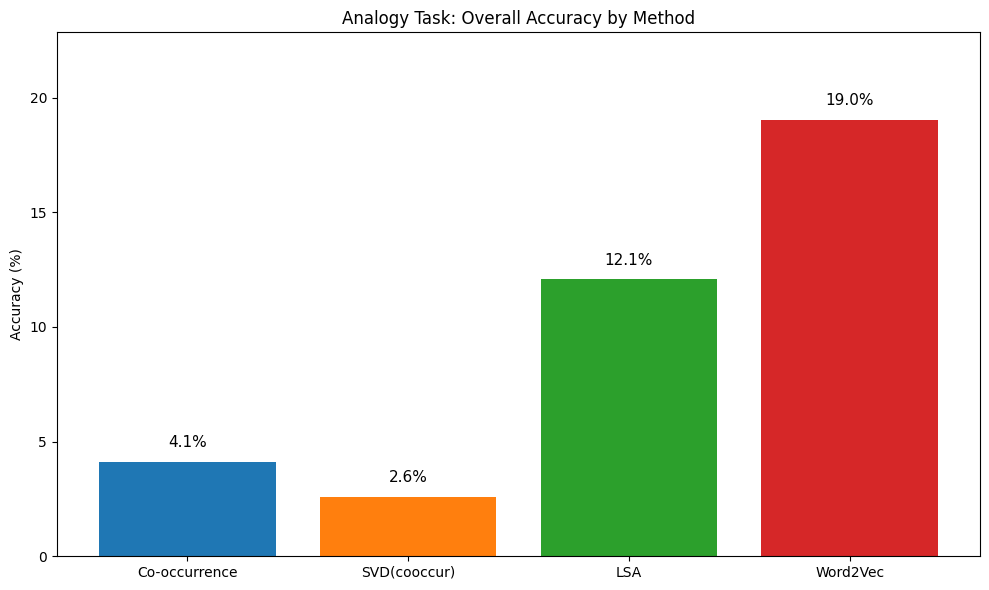

In [24]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

methods = list(all_results.keys())
accuracies = [all_results[m]['overall_accuracy'] * 100 for m in methods]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

bars = ax.bar(methods, accuracies, color=colors)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Analogy Task: Overall Accuracy by Method')
ax.set_ylim(0, max(accuracies) * 1.2)

# Add value labels
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{acc:.1f}%', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

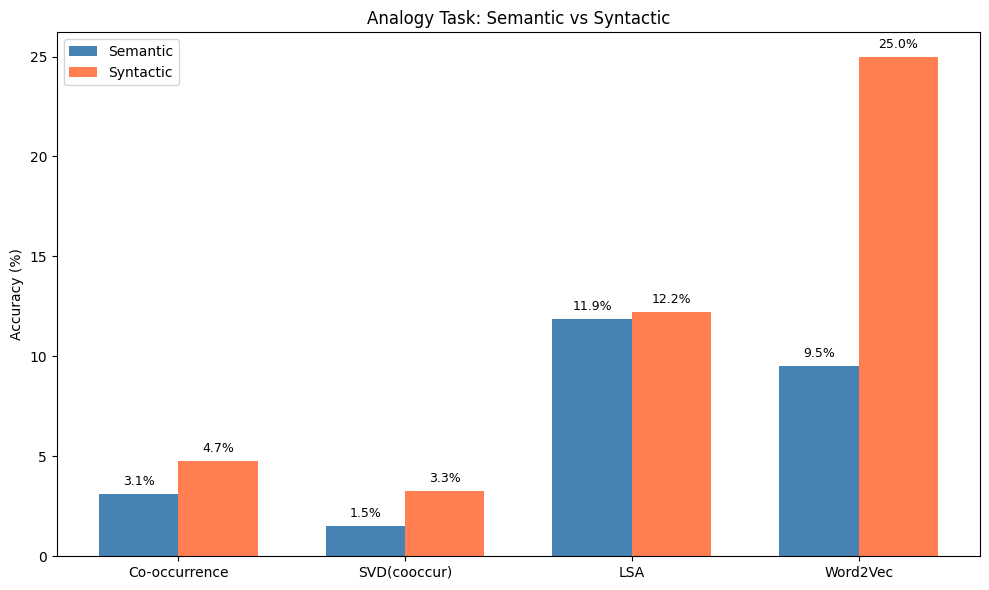

In [25]:
# Plot by category (semantic vs syntactic)
semantic_cats = ['capital-common-countries', 'capital-world', 'currency', 'city-in-state', 'family']
syntactic_cats = [c for c in categories if c not in semantic_cats]

def get_grouped_accuracy(results, cat_list):
    correct = sum(results['by_category'][c]['correct'] for c in cat_list if c in results['by_category'])
    total = sum(results['by_category'][c]['total'] for c in cat_list if c in results['by_category'])
    return correct / total if total > 0 else 0

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(methods))
width = 0.35

semantic_accs = [get_grouped_accuracy(all_results[m], semantic_cats) * 100 for m in methods]
syntactic_accs = [get_grouped_accuracy(all_results[m], syntactic_cats) * 100 for m in methods]

bars1 = ax.bar(x - width/2, semantic_accs, width, label='Semantic', color='steelblue')
bars2 = ax.bar(x + width/2, syntactic_accs, width, label='Syntactic', color='coral')

ax.set_ylabel('Accuracy (%)')
ax.set_title('Analogy Task: Semantic vs Syntactic')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.3,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Summary

**Count-based methods:**
- **Co-occurrence**: raw word-context counts (high-dimensional, sparse)
- **SVD(cooccur)**: SVD on word-context matrix (dense, lower-dimensional)
- **LSA**: SVD on TF-IDF weighted document-word matrix (captures document-level patterns)

**Prediction-based methods:**
- **Word2Vec**: predict context words, learn vectors via SGD

**Key insight:** SVD and Word2Vec are closely related! ([Levy & Goldberg, 2014](https://papers.nips.cc/paper_files/paper/2014/hash/b78666971ceae55a8e87efb7cbfd9ad4-Abstract.html))